In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 1. Import Required Modules

import os
import glob
import keras
import random
import numpy as np
import tensorflow as tf
from keras.layers import *
import keras.backend as k
from keras.models import *
from keras.optimizers import *
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow, imsave, imread_collection
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
# 2. Define Train & Test Path (Images + Mask Path for Train and Test Stages)

TRAIN_IMAGE_PATH = 'gdrive/My Drive/Sand_data/Sand_data/image'
TRAIN_MASK_PATH = 'gdrive/My Drive/Sand_data/Sand_data/label'

In [ ]:
# 3. Initialize Images and Mask Size

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 512, 512, 1

In [ ]:
import glob
import cv2

Train_Input = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob("gdrive/My Drive/Parker_Sand/Image_512x512/*.png"))]
Train_Mask = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob("gdrive/My Drive/Parker_Sand/Label_512x512/*.png"))]

Train_Input = np.array(Train_Input)
Train_Mask = np.array(Train_Mask)

Train_Mask = cv2.normalize(Train_Mask, None, alpha=1,beta=0, norm_type=cv2.NORM_MINMAX)

In [ ]:
import glob
import cv2

Train_Input_1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob("gdrive/My Drive/Berea_Sand/Image_Berea_UF_512/*.png"))]
Train_Mask_1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob("gdrive/My Drive/Berea_Sand/Mask_berea_512/*.png"))]

Train_Input_1 = np.array(Train_Input)
Train_Mask_1 = np.array(Train_Mask)

Train_Mask_1 = cv2.normalize(Train_Mask_1, None, alpha=1,beta=0, norm_type=cv2.NORM_MINMAX)

In [ ]:
Train_Input = (Train_Input, Train_Input_1)
Train_Mask = (Train_Mask, Train_Mask_1)

Train_Input = np.array(Train_Input)
Train_Mask = np.array(Train_Mask)

Train_Input = np.reshape(Train_Input, (-1, Train_Input.shape[2], Train_Input.shape[3]))
Train_Mask = np.reshape(Train_Mask, (-1, Train_Mask.shape[2], Train_Mask.shape[3]))

Training Input


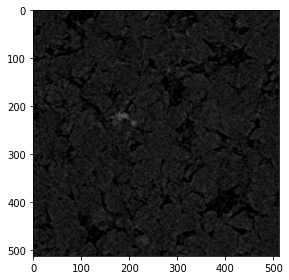

Training Mask


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


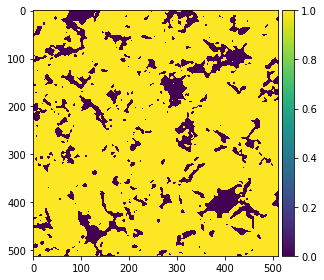

In [ ]:
print('Training Input')
imshow(Train_Input[0])
plt.show()

print('Training Mask')
imshow(np.squeeze(Train_Mask[0]))
plt.show()

In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

def jacard_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (k.sum(y_true_f) + k.sum(y_pred_f) - intersection + 1.0)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = k.sum(k.abs(y_true * y_pred), axis=[1,2])
  union = k.sum(y_true,[1,2])+k.sum(y_pred,[1,2])-intersection
  iou = k.mean((intersection+smooth) / (union+smooth), axis=0)
  return iou

def recall_m(y_true, y_pred):
    true_positives = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    possible_positives = k.sum(k.round(k.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + k.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    predicted_positives = k.sum(k.round(k.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + k.epsilon())
    return precision

def f1_m(y_true, y_pred):
   precision = precision_m(y_true, y_pred)
   recall = recall_m(y_true, y_pred)
   return 2*((precision*recall)/(precision+recall+k.epsilon()))

In [ ]:
def Res_U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):

    inputs = Input(input_size)
    n = Lambda(lambda x:x/255)(inputs)


    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.Ones())(n)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    shortcut1 = Conv2D(16, (1,1), padding='same')(n)

    Res_Path1 = add([shortcut1,c1])
    out1 = Activation('relu')(Res_Path1)

    p1 = MaxPooling2D((2,2))(out1)

    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    shortcut2 = Conv2D(32, (1,1), padding='same')(p1)

    Res_Path2 = add([shortcut2,c2])
    out2 = Activation('relu')(Res_Path2)

    p2 = MaxPooling2D((2,2))(out2)


    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    shortcut3 = Conv2D(64, (1,1), padding='same')(p2)

    Res_Path3 = add([shortcut3,c3])
    out3 = Activation('relu')(Res_Path3)

    p3 = MaxPooling2D((2,2))(out3)


    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), padding='same')(c4)
    shortcut4 = Conv2D(128, (1,1), padding='same')(p3)

    Res_Path4 = add([shortcut4,c4])
    out4 = Activation('relu')(Res_Path4)

    p4 = MaxPooling2D((2,2))(out4)


    c5 = Conv2D(256, (3,3), activation='elu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), padding='same')(c5)
    shortcut5 = Conv2D(256, (1,1), padding='same')(p4)

    Res_Path5 = add([shortcut5,c5])
    out5 = Activation('relu')(Res_Path5)




    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(out5)
    u6 = concatenate([u6, out4])

    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), padding='same')(c6)
    shortcut6 = Conv2D(128, (1,1), padding='same')(u6)

    Res_Path6 = add([shortcut6,c6])
    out6 = Activation('relu')(Res_Path6)



    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(out6)
    u7 = concatenate([u7, out3])

    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), padding='same')(c7)
    shortcut7 = Conv2D(64, (1,1), padding='same')(u7)

    Res_Path7 = add([shortcut7,c7])
    out7 = Activation('relu')(Res_Path7)


    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(out7)
    u8 = concatenate([u8, out2])

    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), padding='same')(c8)
    shortcut8 = Conv2D(32, (1,1), padding='same')(u8)

    Res_Path8 = add([shortcut8,c8])
    out8 = Activation('relu')(Res_Path8)



    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(out8)
    u9 = concatenate([u9, out1], axis = 3)

    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), padding='same')(c9)
    shortcut9 = Conv2D(16, (1,1), padding='same')(u9)

    Res_Path9 = add([shortcut9,c9])
    out9 = Activation('relu')(Res_Path9)


    outputs = Conv2D(1,(1,1), activation='sigmoid')(out9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss = ['binary_crossentropy'], metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0, 1]), tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0]), tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]), f1_m ,precision_m , recall_m, 'accuracy', jacard_coef])
    model.summary()
    return model

In [ ]:
model = Res_U_Net_Segmentation()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
# 7. Show The Results per Epoch

class loss_history(keras.callbacks.Callback):

    def __init__ (self, x=4):
        self.x = x

    def on_epoch_begin(self, epoch, logs={}):

        imshow(np.squeeze(Train_Input[self.x]))
        plt.show()

        imshow(np.squeeze(Train_Mask[self.x]), cmap='Greys_r')
        plt.show()

        preds_train = self.model.predict(np.expand_dims(Train_Input[self.x], axis = 0))
        imshow(np.squeeze(preds_train[0]), cmap='Greys_r')
        plt.show()

Model_Path = 'gdrive/My Drive/Saved_Models/2D_Res_U_Net/Parker_Berea_IoU_Modified_Res_U_Net_BCE_0005_2'

earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint(Model_Path, verbose = 1, save_best_only=True)

In [ ]:
Validation_Input = Train_Input[:400]
Train_Input = Train_Input[400:]
Validation_Mask = Train_Mask[:400]
Train_Mask = Train_Mask[400:]

In [ ]:
Train_Mask.shape

(1600, 512, 512)

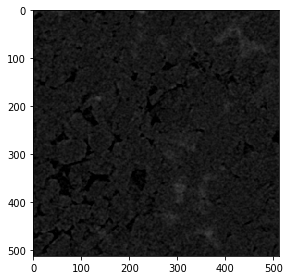

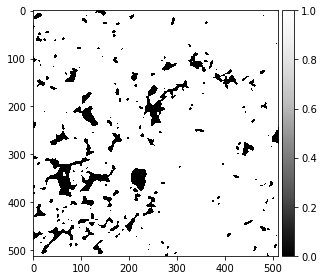

1/1 [==============================] - 9s 9s/step


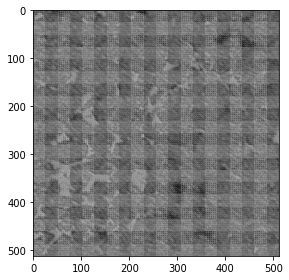

Epoch 1/4
400/400 [==============================] - ETA: 0s - loss: 0.0640 - io_u: 0.0763 - io_u_1: 0.1243 - io_u_2: 0.0283 - f1_m: 0.9825 - precision_m: 0.9780 - recall_m: 0.9891 - accuracy: 0.9706 - jacard_coef: 0.9563
Epoch 1: val_loss improved from inf to 0.03504, saving model to gdrive/My Drive/Saved_Models/2D_Res_U_Net/Parker_Berea_IoU_Modified_Res_U_Net_BCE_0005_2


400/400 [==============================] - 97s 226ms/step - loss: 0.0640 - io_u: 0.0763 - io_u_1: 0.1243 - io_u_2: 0.0283 - f1_m: 0.9825 - precision_m: 0.9780 - recall_m: 0.9891 - accuracy: 0.9706 - jacard_coef: 0.9563 - val_loss: 0.0350 - val_io_u: 0.0895 - val_io_u_1: 0.1407 - val_io_u_2: 0.0384 - val_f1_m: 0.9914 - val_precision_m: 0.9847 - val_recall_m: 0.9982 - val_accuracy: 0.9852 - val_jacard_coef: 0.9777


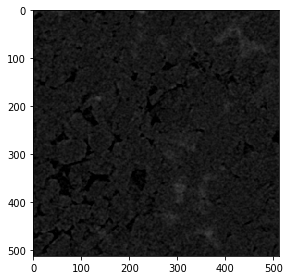

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


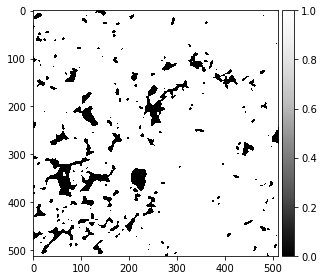

1/1 [==============================] - 0s 17ms/step


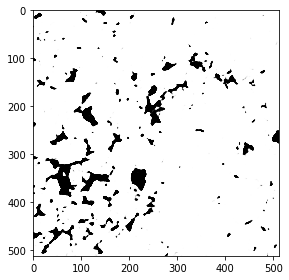

Epoch 2/4
400/400 [==============================] - ETA: 0s - loss: 0.0268 - io_u: 0.1153 - io_u_1: 0.1326 - io_u_2: 0.0980 - f1_m: 0.9936 - precision_m: 0.9930 - recall_m: 0.9942 - accuracy: 0.9887 - jacard_coef: 0.9818
Epoch 2: val_loss did not improve from 0.03504
400/400 [==============================] - 82s 205ms/step - loss: 0.0268 - io_u: 0.1153 - io_u_1: 0.1326 - io_u_2: 0.0980 - f1_m: 0.9936 - precision_m: 0.9930 - recall_m: 0.9942 - accuracy: 0.9887 - jacard_coef: 0.9818 - val_loss: 0.0494 - val_io_u: 0.1455 - val_io_u_1: 0.1543 - val_io_u_2: 0.1367 - val_f1_m: 0.9885 - val_precision_m: 0.9778 - val_recall_m: 0.9996 - val_accuracy: 0.9801 - val_jacard_coef: 0.9751


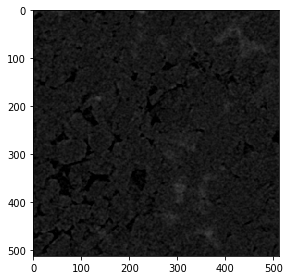

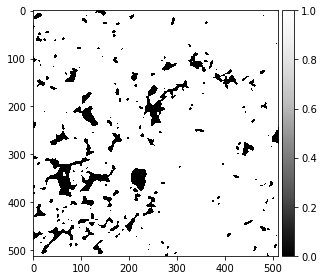

1/1 [==============================] - 0s 17ms/step


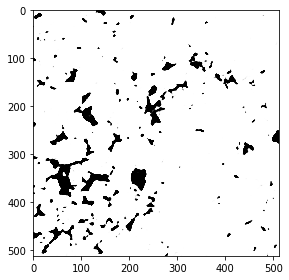

Epoch 3/4
400/400 [==============================] - ETA: 0s - loss: 0.0238 - io_u: 0.1769 - io_u_1: 0.1479 - io_u_2: 0.2058 - f1_m: 0.9943 - precision_m: 0.9938 - recall_m: 0.9947 - accuracy: 0.9899 - jacard_coef: 0.9837
Epoch 3: val_loss improved from 0.03504 to 0.02654, saving model to gdrive/My Drive/Saved_Models/2D_Res_U_Net/Parker_Berea_IoU_Modified_Res_U_Net_BCE_0005_2


400/400 [==============================] - 91s 228ms/step - loss: 0.0238 - io_u: 0.1769 - io_u_1: 0.1479 - io_u_2: 0.2058 - f1_m: 0.9943 - precision_m: 0.9938 - recall_m: 0.9947 - accuracy: 0.9899 - jacard_coef: 0.9837 - val_loss: 0.0265 - val_io_u: 0.2249 - val_io_u_1: 0.1778 - val_io_u_2: 0.2719 - val_f1_m: 0.9935 - val_precision_m: 0.9886 - val_recall_m: 0.9984 - val_accuracy: 0.9887 - val_jacard_coef: 0.9829


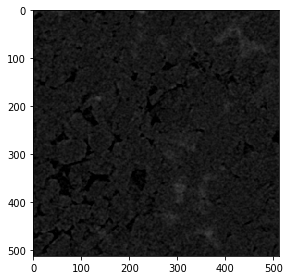

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


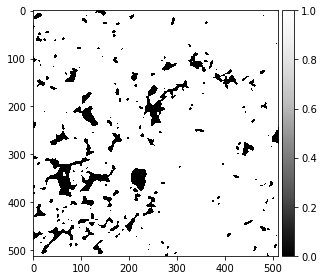

1/1 [==============================] - 0s 18ms/step


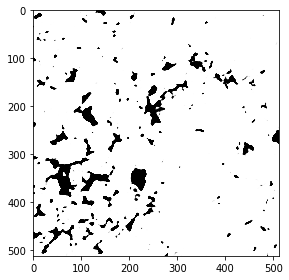

Epoch 4/4
400/400 [==============================] - ETA: 0s - loss: 0.0219 - io_u: 0.2531 - io_u_1: 0.1716 - io_u_2: 0.3345 - f1_m: 0.9947 - precision_m: 0.9944 - recall_m: 0.9950 - accuracy: 0.9907 - jacard_coef: 0.9850
Epoch 4: val_loss improved from 0.02654 to 0.02375, saving model to gdrive/My Drive/Saved_Models/2D_Res_U_Net/Parker_Berea_IoU_Modified_Res_U_Net_BCE_0005_2


400/400 [==============================] - 88s 219ms/step - loss: 0.0219 - io_u: 0.2531 - io_u_1: 0.1716 - io_u_2: 0.3345 - f1_m: 0.9947 - precision_m: 0.9944 - recall_m: 0.9950 - accuracy: 0.9907 - jacard_coef: 0.9850 - val_loss: 0.0237 - val_io_u: 0.3077 - val_io_u_1: 0.2095 - val_io_u_2: 0.4059 - val_f1_m: 0.9942 - val_precision_m: 0.9903 - val_recall_m: 0.9981 - val_accuracy: 0.9899 - val_jacard_coef: 0.9843


In [ ]:
# 8. Train U_NET Model using Training Samples

results = model.fit(Train_Input, Train_Mask,
                    validation_data=(Validation_Input, Validation_Mask),
                    batch_size=4,
                    epochs=4
                    , callbacks=[earlystopper,checkpointer, loss_history()])
